# Check solve_kolmogorov 2

In [1]:
import numpy as np
import matplotlib.pylab as plt

import sys
sys.path.append('../src/')
from solve_kolmogorov import *
from simulate_gillespie import *
from Hypergraphs import *

from scipy.integrate import solve_ivp

In [ ]:
## --- Setup --- ##
test_name = "test_1"

g_type = "complete"

# TODO: increase these values
N = 500
g = CompleteHypergraph(N)

I0 = 5

nsims = 500
run_gillespie_simulations = True

time_max = 20.0

# selected betas for 3 regimes: .25N, .5N, .75N
betas_unscaled_selected = [(1.778, 2.552), (2.556, 8.241), (5.667, 13.414)]
betas_unscaled = betas_unscaled_selected[2] # TODO: select regime, e.g.: 2 for .75N

# beta1 = betas_unscaled[0] / N       # pairwise infection rate
# beta2 = betas_unscaled[1] / (N**2)  # hyperedge contagion rate
# mu    = 1  # recovery rate

beta1 = 2.5 / N       # pairwise infection rate
beta2 = 4.5 / (N**2)  # hyperedge contagion rate
mu    = 1           # recovery rate

print(f"{test_name}: \n")
print(f"\t H = Complete Hypergraph, N = {N}, I0 = {I0}, time_max = {time_max},")
print(f"\t beta1 * N = {beta1 * N}, beta2 * N^2 = {beta2 * (N**2)}, mu = {mu},")
print(f"\t with estimation based on {nsims} Gillespie simulation runs\n")

test_1: 

	 H = Complete Hypergraph, N = 500, I0 = 5, time_max = 20.0,
	 beta1 * N = 2.5, beta2 * N^2 = 4.5, mu = 1,
	 with estimation based on 500 Gillespie simulation runs



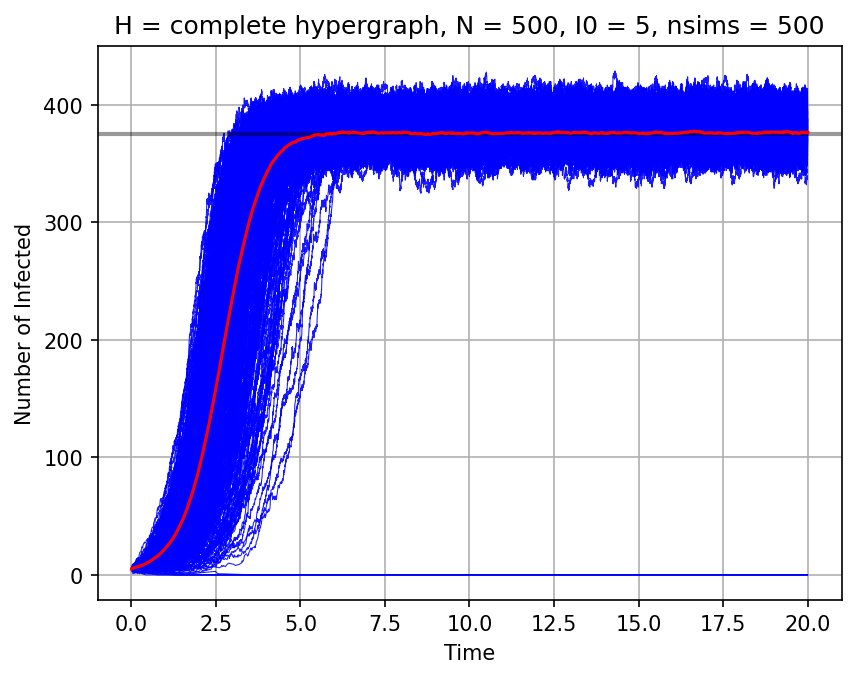

In [9]:
## --- Run Gillespie ---
# I0_gillespie = I0 # TODO: go over the range when necessary
# initial_infections = list(range(I0_gillespie))

run_gillespie_simulations = False
test_name = "test_2"
if run_gillespie_simulations: 
    X_sims = []
    for _ in range(nsims):
        # X_t = gillespie_sim(g, beta1, beta2, mu, initial_infections, time_max)
        X_t = gillespie_sim_complete(N, beta1, beta2, mu, I0, time_max)
        X_sims.append(X_t)

    # save the simulation results
    sim_results = {f'sim_{i}': X_sims[i] for i in range(nsims)}
    np.savez_compressed(f'../results/gillespie-sims_{test_name}.npz', **sim_results)
else: 
    # load simulation results
    sim_results = np.load(f'../results/gillespie-sims_{test_name}.npz', allow_pickle=True)
    X_sims = [sim_results[f'sim_{i}'] for i in range(nsims)]

# plot X_t curves in gray and average curve in red
fig = plt.figure(dpi=150) # set DPI
ax  = plt.subplot()

for X_t in X_sims:
    ax.plot(X_t[0], X_t[2], c="blue", alpha=0.9, linewidth=0.5, rasterized=True)

avg_curve, times = get_average(X_sims, time_max, nsims, delta_t = 0.01)
# avg_curve, times = get_average_corrected(X_sims, time_max, nsims, delta_t = 0.01)

plt.axhline(y=int(0.75 * N), color='black', lw=2, alpha=0.4, linestyle='-')

plt.plot(times, avg_curve, "red")

plt.xlabel("Time")
plt.ylabel("Number of Infected")
plt.grid(True)
plt.title(f"H = complete hypergraph, N = {N}, I0 = {I0}, nsims = {nsims}")
plt.savefig(f"../figures/estimation/complete/{test_name}/gillespie-sims.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()
plt.close(fig) # free up memory

In [11]:
# solve KEs and compare
all_states = list_all_states(g)
M = len(all_states)
ode_system_complete = list_all_ODEs_complete(g, beta1, beta2, mu)

# set the initial condition
p0 = np.zeros(M)
i_set0 = all_states.index(I0)
p0[i_set0] = 1.0 # all other states have prob 0 at time 0
# p0

In [12]:
# solve ode_system_complete over time
t_span = (0.0, time_max)

# times t_i to evaluate in, get saved in sol.t
t_eval = np.linspace(t_span[0], t_span[1], 101)

def f_ode(t, p):
    return ode_system_complete(t, p)

sol = solve_ivp(f_ode, 
                t_span, 
                p0, 
                t_eval=t_eval,
                method="LSODA")

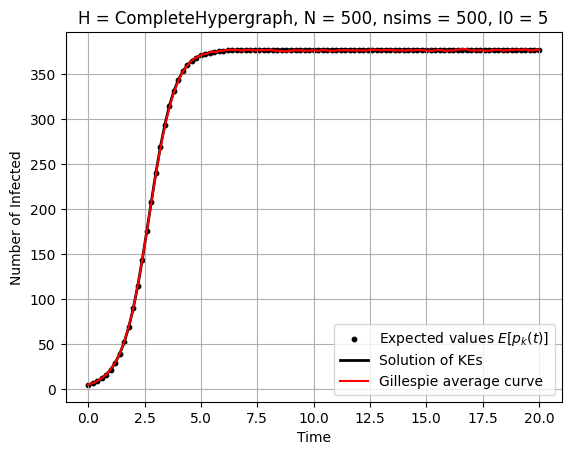

In [13]:
# plot both the expected values of p_{k}(t) 
# and the Gillespie average curve
# on the same figure

expected_values = calculate_expected_values(sol)

plt.figure()
plt.scatter(sol.t, expected_values, s = 10, color="k", 
            label=r"Expected values $E[p_{k}(t)]$")
plt.plot(sol.t, expected_values, lw=2, color="k", label="Solution of KEs")
plt.plot(times, avg_curve, 'red', label="Gillespie average curve")
plt.xlabel("Time")
plt.ylabel("Number of Infected")
plt.legend()
plt.grid(True)
plt.title(f"H = {g.__class__.__name__}, N = {N}, nsims = {nsims}, I0 = {I0}")
plt.savefig("../figures/solutions-kolmogorov/complete/solution-vs-gillespie-avg-200.pdf", 
            format='pdf', bbox_inches='tight') 
plt.show()